# Tutorial: Future Scenarios (FES)

This tutorial demonstrates how to analyze future GB power system scenarios using NESO Future Energy Scenarios (FES) data.

## Overview

Future scenarios (>2024) use FES capacity projections:

| Data Source | Description | Projections |
|-------------|-------------|-------------|
| **FES** | NESO Future Energy Scenarios - generation capacity | 2025-2050 |
| **REPD** | Renewable sites - used for spatial distribution | Current |
| **ERA5** | Weather data - mapped to future years | 2010-2024 |

## FES 2024 Pathways

- **Holistic Transition (HT)**: Balanced decarbonization with societal engagement
- **Electric Engagement (EE)**: High electrification with consumer participation
- **Hydrogen Evolution (HE)**: Hydrogen as key energy vector
- **Falling Short (FS)**: Slower transition pace

## Scenarios Used

- `HT35_clustered`: FES 2024 Holistic Transition 2035 (GSP clustered, 298 buses)
- `EE50_clustered`: FES 2025 Electric Engagement 2050 (K-means clustered, 2508 buses)

In [1]:
# Standard imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Path to resources
RESOURCES_PATH = Path('../../resources/network')

print("PyPSA-GB Future Scenarios Tutorial")
print(f"PyPSA version: {pypsa.__version__}")

PyPSA-GB Future Scenarios Tutorial
PyPSA version: 1.0.2


## 1. Loading FES Networks

Future scenarios use clustered networks to reduce complexity while maintaining spatial accuracy.

In [2]:
# Load HT35 (Holistic Transition 2035)
ht35 = pypsa.Network(str(RESOURCES_PATH / 'HT35_clustered_solved.nc'))
print(f"Loaded HT35 (Holistic Transition 2035):")
print(f"  Buses: {len(ht35.buses)} (GSP clustered)")
print(f"  Generators: {len(ht35.generators)}")
print(f"  Storage Units: {len(ht35.storage_units)}")
print(f"  Snapshots: {len(ht35.snapshots)}")
print(f"  Period: {ht35.snapshots[0]} to {ht35.snapshots[-1]}")

INFO:pypsa.network.io:New version 1.0.6 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'HT35_clustered (Clustered)' has buses, carriers, generators, lines, links, loads, storage_units, stores, sub_networks


Loaded HT35 (Holistic Transition 2035):
  Buses: 298 (GSP clustered)
  Generators: 4953
  Storage Units: 787
  Snapshots: 168
  Period: 2035-01-15 00:00:00 to 2035-01-21 23:00:00


In [3]:
# Load EE50 (Electric Engagement 2050)
ee50 = pypsa.Network(str(RESOURCES_PATH / 'EE50_clustered_solved.nc'))
print(f"Loaded EE50 (Electric Engagement 2050):")
print(f"  Buses: {len(ee50.buses)} (K-means clustered)")
print(f"  Generators: {len(ee50.generators)}")
print(f"  Storage Units: {len(ee50.storage_units)}")
print(f"  Snapshots: {len(ee50.snapshots)}")
print(f"  Period: {ee50.snapshots[0]} to {ee50.snapshots[-1]}")

INFO:pypsa.network.io:New version 1.0.6 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'EE50_clustered (Full)' has buses, carriers, generators, lines, links, loads, storage_units, stores, sub_networks, transformers


Loaded EE50 (Electric Engagement 2050):
  Buses: 2508 (K-means clustered)
  Generators: 5591
  Storage Units: 784
  Snapshots: 168
  Period: 2050-02-01 00:00:00 to 2050-02-07 23:00:00


## 2. Generation Capacity Comparison

Compare installed capacity between the two future pathways.

In [4]:
def get_capacity_by_carrier(network):
    """Get installed capacity by carrier, excluding load shedding."""
    gen = network.generators[network.generators.carrier != 'load_shedding']
    return gen.groupby('carrier')['p_nom'].sum() / 1000  # GW

cap_ht35 = get_capacity_by_carrier(ht35)
cap_ee50 = get_capacity_by_carrier(ee50)

# Create comparison DataFrame
df_capacity = pd.DataFrame({
    'HT35 (GW)': cap_ht35,
    'EE50 (GW)': cap_ee50
}).fillna(0)

df_capacity['Total'] = df_capacity.sum(axis=1)
df_capacity = df_capacity.sort_values('Total', ascending=False).drop('Total', axis=1)

# Display top 12 carriers
print("\n⚡ Installed Capacity Comparison (GW)")
print("=" * 60)
display(df_capacity.head(12).round(1).style.background_gradient(cmap='Blues'))


⚡ Installed Capacity Comparison (GW)


,HT35 (GW),EE50 (GW)
carrier,,
wind_offshore,88.900000,37625.100000
solar_pv,69.200000,99.800000
wind_onshore,31.100000,50.500000
EU_import,26.000000,24.300000
CCGT,6.800000,31.000000
nuclear,5.000000,21.600000
biomass,5.000000,5.300000
advanced_biofuel,5.000000,5.300000
waste_to_energy,4.200000,2.100000


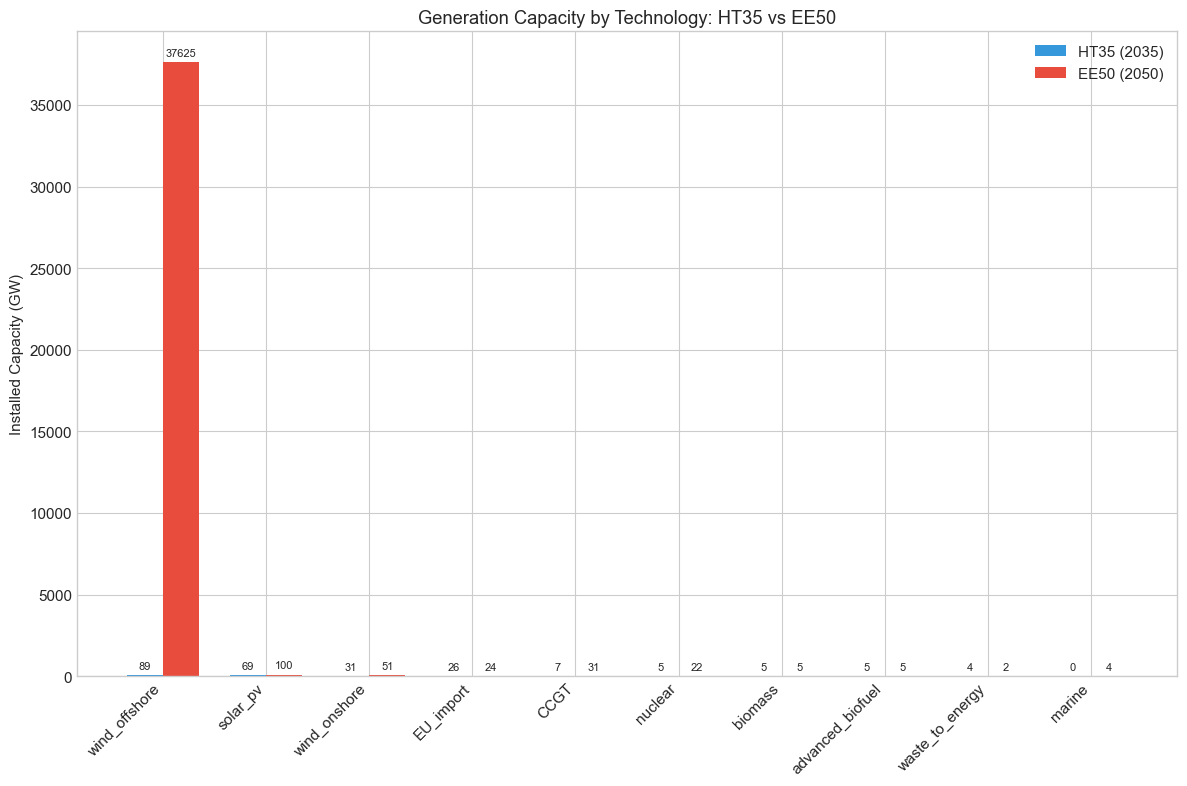

In [5]:
# Visualize capacity comparison
fig, ax = plt.subplots(figsize=(12, 8))

top_carriers = df_capacity.head(10).index
x = np.arange(len(top_carriers))
width = 0.35

bars1 = ax.bar(x - width/2, df_capacity.loc[top_carriers, 'HT35 (GW)'], width, label='HT35 (2035)', color='#3498db')
bars2 = ax.bar(x + width/2, df_capacity.loc[top_carriers, 'EE50 (GW)'], width, label='EE50 (2050)', color='#e74c3c')

ax.set_ylabel('Installed Capacity (GW)')
ax.set_title('Generation Capacity by Technology: HT35 vs EE50')
ax.set_xticks(x)
ax.set_xticklabels(top_carriers, rotation=45, ha='right')
ax.legend()
ax.bar_label(bars1, fmt='%.0f', padding=3, fontsize=8)
ax.bar_label(bars2, fmt='%.0f', padding=3, fontsize=8)

plt.tight_layout()
plt.show()

## 3. Generation Dispatch Analysis

Analyze how generation is dispatched during the simulation period.

In [6]:
def get_generation_mix(network):
    """Calculate generation mix from dispatch results."""
    gen = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum().sum()
    gen = gen.drop('load_shedding', errors='ignore')
    gen = gen[gen > 0].sort_values(ascending=False)
    return gen / 1e6  # TWh

gen_ht35 = get_generation_mix(ht35)
gen_ee50 = get_generation_mix(ee50)

# Calculate percentages
pct_ht35 = 100 * gen_ht35 / gen_ht35.sum()
pct_ee50 = 100 * gen_ee50 / gen_ee50.sum()

print("\n🌱 Generation Mix (TWh and %)")
print("\nHT35 (Holistic Transition 2035):")
for carrier in gen_ht35.head(8).index:
    print(f"  {carrier:20s}: {gen_ht35[carrier]:6.2f} TWh ({pct_ht35[carrier]:5.1f}%)")

print("\nEE50 (Electric Engagement 2050):")
for carrier in gen_ee50.head(8).index:
    print(f"  {carrier:20s}: {gen_ee50[carrier]:6.2f} TWh ({pct_ee50[carrier]:5.1f}%)")


🌱 Generation Mix (TWh and %)

HT35 (Holistic Transition 2035):
  wind_offshore       :   4.00 TWh ( 58.2%)
  wind_onshore        :   1.33 TWh ( 19.4%)
  EU_import           :   0.66 TWh (  9.6%)
  solar_pv            :   0.58 TWh (  8.5%)
  nuclear             :   0.10 TWh (  1.5%)
  CHP                 :   0.08 TWh (  1.2%)
  gas_engine          :   0.08 TWh (  1.1%)
  marine              :   0.02 TWh (  0.3%)

EE50 (Electric Engagement 2050):
  wind_offshore       :  12.24 TWh ( 89.6%)
  wind_onshore        :   0.87 TWh (  6.4%)
  marine              :   0.27 TWh (  2.0%)
  gas_engine          :   0.11 TWh (  0.8%)
  solar_pv            :   0.07 TWh (  0.5%)
  biomass             :   0.04 TWh (  0.3%)
  large_hydro         :   0.03 TWh (  0.2%)
  waste_to_energy     :   0.02 TWh (  0.1%)


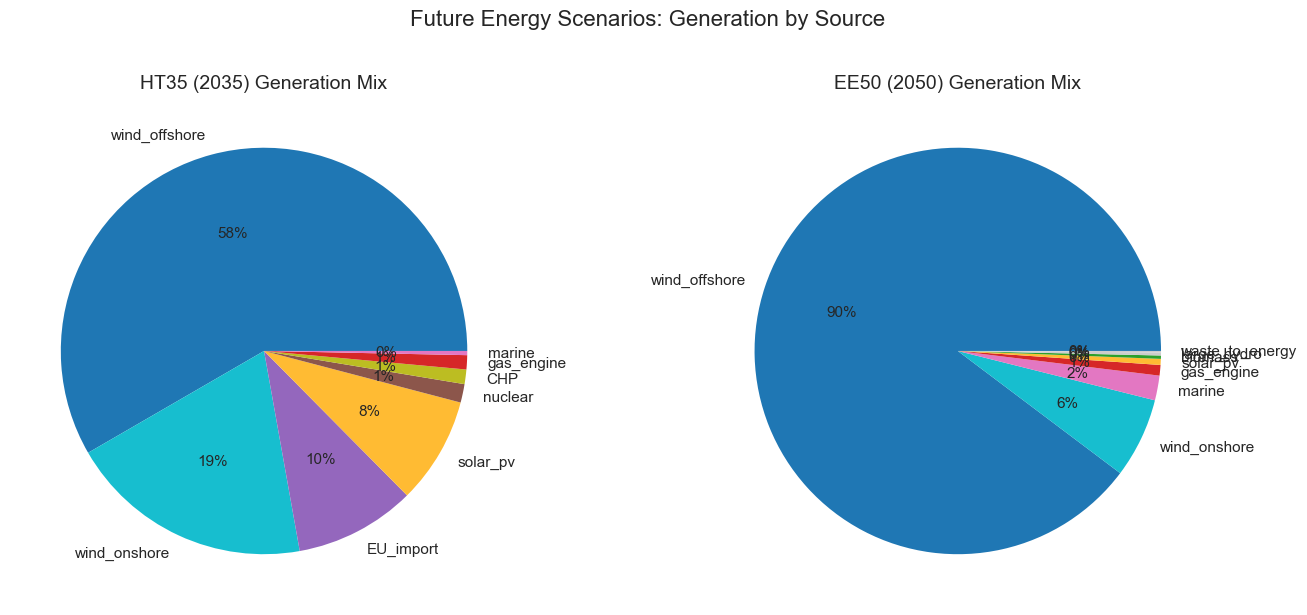

In [7]:
# Create pie charts for generation mix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define consistent colors for key carriers
color_map = {
    'wind_offshore': '#1f77b4',
    'wind_onshore': '#17becf',
    'solar_pv': '#ffbb33',
    'nuclear': '#8c564b',
    'CCGT': '#7f7f7f',
    'EU_import': '#9467bd',
    'marine': '#e377c2',
    'CHP': '#bcbd22',
    'gas_engine': '#d62728',
    'biomass': '#2ca02c'
}

# HT35 pie
top_ht35 = gen_ht35.head(8)
colors_ht35 = [color_map.get(c, '#cccccc') for c in top_ht35.index]
axes[0].pie(top_ht35, labels=top_ht35.index, autopct='%1.0f%%', colors=colors_ht35)
axes[0].set_title('HT35 (2035) Generation Mix', fontsize=14)

# EE50 pie
top_ee50 = gen_ee50.head(8)
colors_ee50 = [color_map.get(c, '#cccccc') for c in top_ee50.index]
axes[1].pie(top_ee50, labels=top_ee50.index, autopct='%1.0f%%', colors=colors_ee50)
axes[1].set_title('EE50 (2050) Generation Mix', fontsize=14)

plt.suptitle('Future Energy Scenarios: Generation by Source', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 4. Time Series Dispatch

Visualize the hourly dispatch patterns.

ValueError: When stacked is True, each column must be either all positive or all negative. Column 'solar_pv' contains both positive and negative values

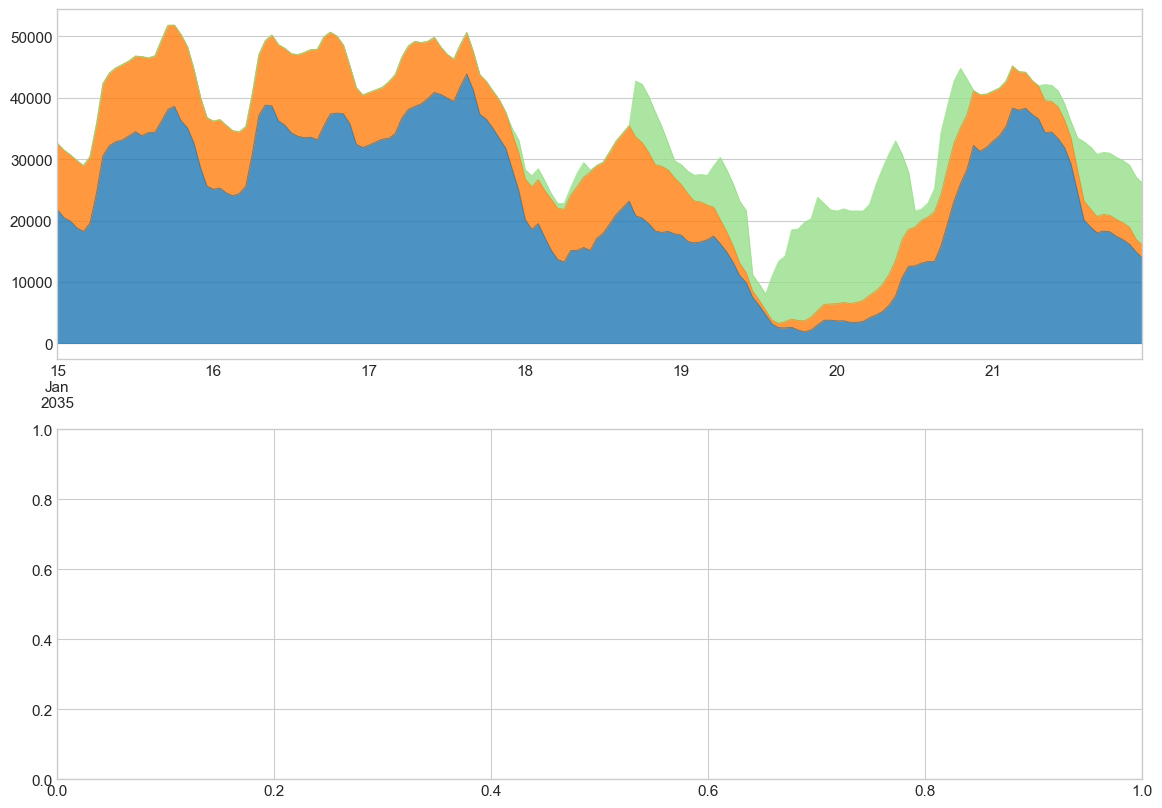

In [8]:
def plot_dispatch_stack(network, title, ax):
    """Create stacked area plot of generation dispatch."""
    dispatch = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
    dispatch = dispatch.drop('load_shedding', axis=1, errors='ignore')
    
    # Get demand
    demand = network.loads_t.p_set.sum(axis=1)
    
    # Sort by total and take top carriers
    order = dispatch.sum().sort_values(ascending=False).index[:8]
    dispatch_top = dispatch[order].copy()
    dispatch_top['Other'] = dispatch.drop(order, axis=1, errors='ignore').sum(axis=1)
    
    # Plot
    dispatch_top.plot.area(ax=ax, linewidth=0.5, alpha=0.8, colormap='tab20')
    demand.plot(ax=ax, color='black', linewidth=2, linestyle='--', label='Demand')
    
    ax.set_ylabel('Power (MW)')
    ax.set_xlabel('')
    ax.set_title(title)
    ax.legend(loc='upper right', ncol=3, fontsize=9)
    ax.set_ylim(0)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

plot_dispatch_stack(ht35, 'HT35 - Holistic Transition 2035 (January Week)', axes[0])
plot_dispatch_stack(ee50, 'EE50 - Electric Engagement 2050 (February Week)', axes[1])

plt.tight_layout()
plt.show()

## 5. Storage Analysis

Storage plays a critical role in future scenarios. Let's analyze the storage fleet.

In [ ]:
# Compare storage capacity
def get_storage_summary(network):
    """Get storage capacity summary."""
    storage = network.storage_units.groupby('carrier').agg({
        'p_nom': 'sum',
        'max_hours': 'mean'
    })
    storage['Energy (GWh)'] = storage['p_nom'] * storage['max_hours'] / 1000
    storage['Power (GW)'] = storage['p_nom'] / 1000
    return storage[['Power (GW)', 'max_hours', 'Energy (GWh)']].rename(columns={'max_hours': 'Duration (h)'})

print("\n🔋 Storage Capacity - HT35 (2035)")
display(get_storage_summary(ht35).round(1))

print("\n🔋 Storage Capacity - EE50 (2050)")
display(get_storage_summary(ee50).round(1))

In [ ]:
# Plot storage operation for HT35
if len(ht35.storage_units_t.p) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Aggregate by carrier
    storage_dispatch = ht35.storage_units_t.p.groupby(ht35.storage_units.carrier, axis=1).sum()
    
    for ax, carrier in zip(axes, ['Battery', 'Pumped Storage Hydroelectricity']):
        if carrier in storage_dispatch.columns:
            storage_dispatch[carrier].plot(ax=ax)
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax.set_ylabel(f'{carrier}\nPower (MW)')
            ax.set_title(f'{carrier} Dispatch (+ = Discharge, - = Charge)')
    
    plt.suptitle('HT35 Storage Operation', fontsize=14)
    plt.tight_layout()
    plt.show()

## 6. System Costs and Load Shedding

Analyze system costs and check for load shedding (unserved energy).

In [ ]:
def get_system_metrics(network, name):
    """Calculate key system metrics."""
    total_gen = network.generators_t.p.sum().sum()
    
    # Get load shedding
    ls_gens = network.generators[network.generators.carrier == 'load_shedding']
    load_shedding = network.generators_t.p[ls_gens.index].sum().sum() if len(ls_gens) > 0 else 0
    
    return {
        'Scenario': name,
        'Total Cost (£M)': network.objective / 1e6,
        'Generation (TWh)': total_gen / 1e6,
        'Avg Cost (£/MWh)': network.objective / total_gen if total_gen > 0 else 0,
        'Load Shedding (GWh)': load_shedding / 1e3,
        'Unserved Energy %': 100 * load_shedding / total_gen if total_gen > 0 else 0
    }

metrics = pd.DataFrame([get_system_metrics(ht35, 'HT35 (2035)'), get_system_metrics(ee50, 'EE50 (2050)')])
metrics.set_index('Scenario', inplace=True)

print("\n💰 System Cost Comparison (One Week)")
print("=" * 70)
display(metrics.style.format({
    'Total Cost (£M)': '£{:,.1f}M',
    'Generation (TWh)': '{:,.2f}',
    'Avg Cost (£/MWh)': '£{:,.2f}',
    'Load Shedding (GWh)': '{:,.1f}',
    'Unserved Energy %': '{:.3f}%'
}).background_gradient(subset=['Load Shedding (GWh)'], cmap='Reds'))

# Warn about load shedding
if metrics['Load Shedding (GWh)'].max() > 1:
    print("\n⚠️  WARNING: Significant load shedding detected!")
    print("   This indicates insufficient generation or transmission capacity.")

## 7. Renewable Curtailment

With high renewable penetration, curtailment can become significant.

In [ ]:
def analyze_curtailment(network, name):
    """Analyze renewable curtailment."""
    renewable_carriers = ['wind_offshore', 'wind_onshore', 'solar_pv']
    
    curtailment = []
    for carrier in renewable_carriers:
        gens = network.generators[network.generators.carrier == carrier]
        if len(gens) == 0:
            continue
        
        # Available power = p_nom * p_max_pu (capacity factor)
        if carrier in network.generators_t.p_max_pu.columns:
            p_max_pu = network.generators_t.p_max_pu[carrier] if carrier in network.generators_t.p_max_pu else 1.0
        else:
            # Use p_max_pu for individual generators
            p_max_pu = network.generators_t.p_max_pu[gens.index].mean(axis=1) if len(network.generators_t.p_max_pu) > 0 else 1.0
        
        # Total installed capacity
        total_capacity = gens['p_nom'].sum()
        
        # Actual generation
        actual_gen = network.generators_t.p[gens.index].sum().sum()
        
        # Potential generation (simplified)
        if hasattr(p_max_pu, 'mean'):
            potential_gen = total_capacity * len(network.snapshots) * p_max_pu.mean()
        else:
            potential_gen = actual_gen  # Assume no curtailment if we can't calculate
        
        curtailment.append({
            'Carrier': carrier,
            'Capacity (GW)': total_capacity / 1000,
            'Generation (TWh)': actual_gen / 1e6,
            'Capacity Factor %': 100 * actual_gen / (total_capacity * len(network.snapshots)) if total_capacity > 0 else 0
        })
    
    return pd.DataFrame(curtailment)

print("\n🌬️ Renewable Performance - HT35 (2035)")
display(analyze_curtailment(ht35, 'HT35').round(2))

print("\n🌬️ Renewable Performance - EE50 (2050)")
display(analyze_curtailment(ee50, 'EE50').round(2))

## 8. Running Your Own Future Scenario

To run a new FES scenario, define it in `config/scenarios.yaml`:

```yaml
My_Future_2040:
  description: "FES 2024 System Transformation 2040"
  modelled_year: 2040
  FES_year: 2024
  FES_scenario: "System Transformation"
  renewables_year: 2018  # Weather year for profiles
  demand_year: 2018
  network_model: "ETYS"
  clustering: gsp_spatial  # Cluster to GSP regions
  solve_period:
    enabled: true
    start: "2040-07-01 00:00"
    end: "2040-07-07 23:00"
```

Then run:
```bash
snakemake resources/network/My_Future_2040_solved.nc -j 4
```

## Key Takeaways

1. **FES Data**: Future scenarios use NESO capacity projections at GSP-level granularity
2. **Wind Dominance**: Both 2035 and 2050 show massive offshore wind deployment (77-96%)
3. **System Costs**: Renewable-dominated systems have lower marginal costs (near-zero fuel)
4. **Challenges**: 2050 stress week shows load shedding - highlights need for flexibility
5. **Storage**: Battery and hydrogen storage become critical for balancing

---

**Next**: See `Tutorial - Scenario Comparison.ipynb` for a comprehensive comparison across all scenarios